In [1]:
import pandas as pd
from tables import *
import pdb
import numpy as np
import gcp.bigquery as bq
import gcp.storage as storage

seed = 13
np.random.seed(seed)

# Put all categorical data first for easier implementation of One Hot Encoding.
fields_str = """
gap	timeofday_slot	day_in_week	weather_1_slots_ago	weather_2_slots_ago	weather_3_slots_ago	
tj_level1_1_slots_ago	tj_level2_1_slots_ago	tj_level3_1_slots_ago	tj_level4_1_slots_ago	
tj_level1_2_slots_ago	tj_level2_2_slots_ago	tj_level3_2_slots_ago	tj_level4_2_slots_ago	
tj_level1_3_slots_ago	tj_level2_3_slots_ago	tj_level3_3_slots_ago	tj_level4_3_slots_ago	
temperature_1_slots_ago	pm25_1_slots_ago	
temperature_2_slots_ago	pm25_2_slots_ago	
temperature_3_slots_ago	pm25_3_slots_ago	
gap_1_slots_ago	sum_price_1_slots_ago	
gap_2_slots_ago	sum_price_2_slots_ago	
gap_3_slots_ago	sum_price_3_slots_ago	
f1	f11	f11_1	f11_2	f11_3	f11_4	f11_5	f11_6	f11_7	
f11_8	f13_4	f13_8	f14	f14_1	f14_10	f14_2	f14_3	f14_6	f14_8	f15	f15_1	
f15_2	f15_3	f15_4	f15_6	f15_7	f15_8	f16	f16_1	f16_10	f16_11	f16_12	f16_3	
f16_4	f16_6	f17	f17_2	f17_3	f17_4	f17_5	f19	f19_1	f19_2	f19_3	f19_4	f1_1	
f1_10	f1_11	f1_2	f1_3	f1_4	f1_5	f1_6	f1_7	f1_8	f20	f20_1	f20_2	
f20_4	f20_5	f20_6	f20_7	f20_8	f20_9	f21_1	f21_2	f22	f22_1	f22_2	f22_3	
f22_4	f22_5	f23	f23_1	f23_2	f23_3	f23_4	f23_5	f23_6	f24	f24_1	f24_2	f24_3	
f25	f25_1	f25_3	f25_7	f25_8	f25_9	f2_1	f2_10	f2_11	f2_12	f2_13	f2_2	
f2_4	f2_5	f2_6	f2_7	f2_8	f3_1	f3_2	f3_3	f4	f4_1	f4_10	f4_11	
f4_13	f4_14	f4_16	f4_17	f4_18	f4_2	f4_3	f4_5	f4_6	f4_7	f4_8	f4_9	
f5	f5_1	f5_3	f5_4	f6	f6_1	f6_2	f6_4	f7	f8	f8_1	f8_2	f8_3	f8_4	
f8_5
"""
fields = map(lambda x: x.strip(), fields_str.split('\t'))
features = fields[1:]

# Use this instead of len(features) since this variable can change
# e.g. when one hot encoding is used and/or new features are added.
n_features = len(features)


datafile_path = 'xjk_pytable.h5'

In [2]:
RECREATE_TABLE = False

# Training data

def create_train_table(fileh, datafile_path, fields):
  train = fileh.create_group('/', 'train', 'Training tables')
  tabledef = {}
  for field in fields:
    tabledef[field] = Float64Col()
  gaps = fileh.create_table(train, 'gaps', tabledef)
  gaps.flush()
  print "flushed"
  return fileh

try:
  fileh = open_file(datafile_path, mode = 'r')
  fileh.root.train.gaps
  if RECREATE_TABLE:
    print "(train) recreate table"
    fileh.close()
    fileh = open_file(datafile_path, mode = 'w')
    fileh = create_train_table(fileh, datafile_path, fields)
  else:
    print "(train) file created, pass..."
except:
  print "(train) file doesn't exist, create table"
  if 'fileh' in vars() or 'fileh' in globals():
    fileh.close()
  fileh = open_file(datafile_path, mode = 'a')
  fileh = create_train_table(fileh, datafile_path, fields)

fileh.close()

# Test data

def create_test_table(fileh, datafile_path, fields):
  test = fileh.create_group('/', 'test', 'Test tables')
  tabledef = {}
  for field in fields:
    tabledef[field] = Float64Col()
  gaps = fileh.create_table(test, 'gaps', tabledef)
  gaps.flush()
  print "flushed"
  return fileh

try:
  fileh = open_file(datafile_path, mode = 'r')
  fileh.root.test.gaps
  if RECREATE_TABLE:
    print "(test) recreate table"
    fileh.close()
    fileh = open_file(datafile_path, mode = 'a')
    fileh = create_test_table(fileh, datafile_path, fields)
  else:
    print "(test) file created, pass..."
except:
  print "(test) file doesn't exist, create table"
  if 'fileh' in vars() or 'fileh' in globals():
    fileh.close()
  fileh = open_file(datafile_path, mode = 'a')
  fileh = create_test_table(fileh, datafile_path, fields)

print "\nfiledata information:"
print(fileh)
fileh.close()

(train) file created, pass...
(test) file created, pass...

filedata information:
xjk_pytable.h5 (File) ''
Last modif.: 'Sun Jul  3 10:48:58 2016'
Object Tree: 
/ (RootGroup) ''
/test (Group) 'Test tables'
/test/gaps (Table(0,)) ''
/train (Group) 'Training tables'
/train/gaps (Table(102592,)) ''



# Load Dataset

In [3]:
print ', '.join(fields)

gap, timeofday_slot, day_in_week, weather_1_slots_ago, weather_2_slots_ago, weather_3_slots_ago, tj_level1_1_slots_ago, tj_level2_1_slots_ago, tj_level3_1_slots_ago, tj_level4_1_slots_ago, tj_level1_2_slots_ago, tj_level2_2_slots_ago, tj_level3_2_slots_ago, tj_level4_2_slots_ago, tj_level1_3_slots_ago, tj_level2_3_slots_ago, tj_level3_3_slots_ago, tj_level4_3_slots_ago, temperature_1_slots_ago, pm25_1_slots_ago, temperature_2_slots_ago, pm25_2_slots_ago, temperature_3_slots_ago, pm25_3_slots_ago, gap_1_slots_ago, sum_price_1_slots_ago, gap_2_slots_ago, sum_price_2_slots_ago, gap_3_slots_ago, sum_price_3_slots_ago, f1, f11, f11_1, f11_2, f11_3, f11_4, f11_5, f11_6, f11_7, f11_8, f13_4, f13_8, f14, f14_1, f14_10, f14_2, f14_3, f14_6, f14_8, f15, f15_1, f15_2, f15_3, f15_4, f15_6, f15_7, f15_8, f16, f16_1, f16_10, f16_11, f16_12, f16_3, f16_4, f16_6, f17, f17_2, f17_3, f17_4, f17_5, f19, f19_1, f19_2, f19_3, f19_4, f1_1, f1_10, f1_11, f1_2, f1_3, f1_4, f1_5, f1_6, f1_7, f1_8, f20, f20_1, 

In [4]:
%%sql --module q_all

SELECT *
FROM [datalab-projects-1331:xjk_algo_comp.gaps]
WHERE gap > 0

In [5]:
%%timeit -n 1 -r 1

fileh1 = open_file(datafile_path, mode = 'r')

if fileh1.root.train.gaps.nrows == 0:
  query = bq.Query(q_all)
  tableresult = query.results()
  fileh1.close()
  fileh1 = open_file(datafile_path, mode = 'a')
  gaps_table = fileh1.root.train.gaps

  gap = gaps_table.row
  print 'there are {} rows'.format(tableresult.length)
  for rcounter, row in enumerate(tableresult):
    for field in fields:
      gap[field] = row[field]
    gap.append()
    if rcounter % 5000 == 0:
      print 'processed {} rows'.format(rcounter)
  gaps_table.flush()
  
else:
  print "datafile not empty, pass..."

fileh1.close()

datafile not empty, pass...
1 loop, best of 1: 68.3 ms per loop


In [6]:
fileh1 = open_file(datafile_path, mode = 'r')

object = fileh1.get_node('/train', 'gaps')
object_array_data = object.read()
print fileh1.root.train.gaps.nrows
fileh1.close()

102592


In [7]:
# Sample, should return nan
object_array_data[5]['gap_1_slots_ago']

nan

In [8]:
# %%timeit -n 1 -r 1

# Convert to vectorized array that we can use in further processing.
all_data = np.zeros((object_array_data.shape[0], len(fields)))
print 'there are {} rows'.format(object_array_data.shape[0])
for rcounter, row in enumerate(object_array_data):
  for fcounter, field in enumerate(fields):
    all_data[rcounter, fcounter] = row[field]
  if rcounter % 5000 == 0:
    print 'processed {} rows'.format(rcounter)
all_data_original = np.copy(all_data)

there are 102592 rows
processed 0 rows
processed 5000 rows
processed 10000 rows
processed 15000 rows
processed 20000 rows
processed 25000 rows
processed 30000 rows
processed 35000 rows
processed 40000 rows
processed 45000 rows
processed 50000 rows
processed 55000 rows
processed 60000 rows
processed 65000 rows
processed 70000 rows
processed 75000 rows
processed 80000 rows
processed 85000 rows
processed 90000 rows
processed 95000 rows
processed 100000 rows


In [9]:
# This chunk does further wrangling to dataset to produce training and test sets.

# Useful code to check NaN and Inf values. This is needed since these values would
# cause "Input contains NaN, infinity or a value too large for dtype('float32')
# errors when left unchecked.
print "Checkinf for NaN and Inf"
print "np.nan=", np.where(np.isnan(all_data_original))
print "is.inf=", np.where(np.isinf(all_data_original))
print "np.max=", np.max(abs(all_data_original))

# Impute all NaN with numbers (not sure what to replace inf yet)
# all_data[np.isnan(all_data_original)] = 0
# all_data[np.isinf(all_data)] = 0

Checkinf for NaN and Inf
np.nan= (array([     5,      5,     19, ..., 102578, 102581, 102581]), array([24, 25, 24, ..., 25, 28, 29]))
is.inf= (array([], dtype=int64), array([], dtype=int64))
np.max= nan
Checkinf for NaN and Inf
np.nan= (array([], dtype=int64), array([], dtype=int64))
is.inf= (array([], dtype=int64), array([], dtype=int64))
np.max= 461563.0


# Data Exploration - Find NaN values

In [10]:
# This is how to get position of NaNs

nulls = np.isnan(all_data_original)
nullspos = np.column_stack(np.where(nulls==True))
nullspos

array([[     5,     24],
       [     5,     25],
       [    19,     24],
       ..., 
       [102578,     25],
       [102581,     28],
       [102581,     29]])

In [11]:
x = [[np.NaN, 1, 2, 3],
     [1, 2, 3, np.NaN]]
xn = np.isnan(x)
xnp = np.column_stack(np.where(xn==True))
xnp

array([[0, 0],
       [1, 3]])

In [12]:
from operator import itemgetter
print "total data points:", (all_data_original.shape[0] * all_data_original.shape[1])
print "number of missing values:", nullspos.shape[0]
missing_features = itemgetter(*np.unique(nullspos[:,1]).tolist())(fields)
missing_features_table = pd.DataFrame(columns=['id', 'field', 'missing data points'])

for id, field in enumerate(fields):
  total_missing = len(np.where(nullspos[:,1]==id)[0])
  if total_missing > 0:
    missing_features_table = missing_features_table.append({
        'id': id,
        'field': field,
        'missing data points': total_missing
      }, ignore_index=True)
missing_features_table['missing data points'] = \
  missing_features_table['missing data points'].astype('int64')
missing_features_table['id'] = \
  missing_features_table['id'].astype('int64')
missing_features_table.sort_values(['missing data points', 'id'], ascending=[False, True])

total data points: 16825088
number of missing values: 117619


,id,field,missing data points
0,3,weather_1_slots_ago,7473
1,4,weather_2_slots_ago,7473
2,5,weather_3_slots_ago,7473
15,18,temperature_1_slots_ago,7473
16,19,pm25_1_slots_ago,7473
17,20,temperature_2_slots_ago,7473
18,21,pm25_2_slots_ago,7473
19,22,temperature_3_slots_ago,7473
20,23,pm25_3_slots_ago,7473
25,28,gap_3_slots_ago,5430


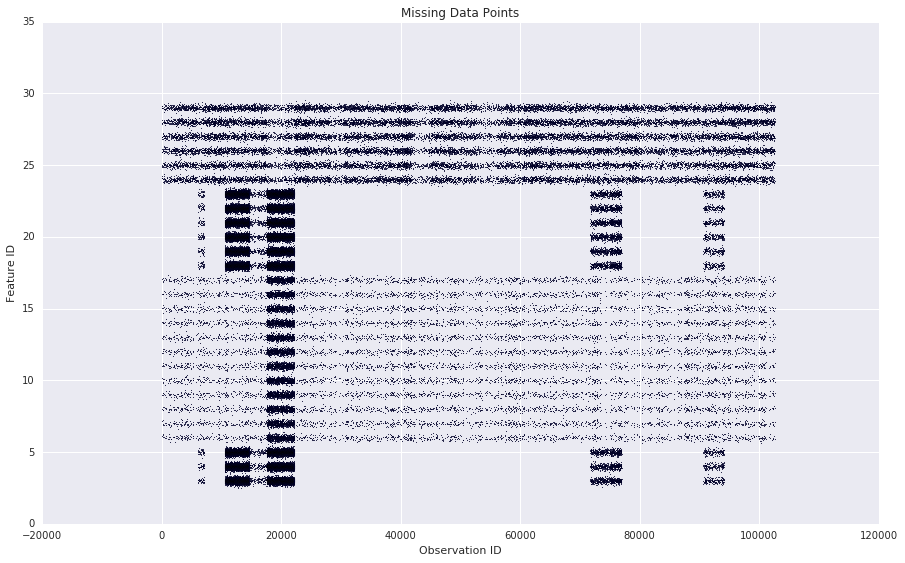

In [13]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 9.0)
def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev
_ = plt.scatter(nullspos[:,0], rand_jitter(nullspos[:,1]), s=0.5)
_ = plt.title('Missing Data Points')
_ = plt.ylabel('Feature ID')
_ = plt.xlabel('Observation ID')

Cross-check with dataset:

In [14]:
%%sql
SELECT COUNT(*) AS count FROM [datalab-projects-1331:xjk_algo_comp.gaps]
WHERE IS_NAN(sum_price_1_slots_ago) = true
AND gap > 0

count
4502


## Examine observation with NaN value in detail

In this step we are analyzing NaN value from one row to find out what the problem exactly was.

In [15]:
%%sql
SELECT * FROM [datalab-projects-1331:xjk_algo_comp.gaps]
WHERE IS_NAN(sum_price_1_slots_ago) = true
AND gap > 0
LIMIT 1

district_id,timeslot,day_in_week,timeofday_slot,tj_level1_1_slots_ago,tj_level2_1_slots_ago,tj_level3_1_slots_ago,tj_level4_1_slots_ago,tj_level1_2_slots_ago,tj_level2_2_slots_ago,tj_level3_2_slots_ago,tj_level4_2_slots_ago,tj_level1_3_slots_ago,tj_level2_3_slots_ago,tj_level3_3_slots_ago,tj_level4_3_slots_ago,weather_1_slots_ago,temperature_1_slots_ago,pm25_1_slots_ago,weather_2_slots_ago,temperature_2_slots_ago,pm25_2_slots_ago,weather_3_slots_ago,temperature_3_slots_ago,pm25_3_slots_ago,gap_1_slots_ago,sum_price_1_slots_ago,gap_2_slots_ago,sum_price_2_slots_ago,gap_3_slots_ago,sum_price_3_slots_ago,f1,f11,f11_1,f11_2,f11_3,f11_4,f11_5,f11_6,f11_7,f11_8,f13_4,f13_8,f14,f14_1,f14_10,f14_2,f14_3,f14_6,f14_8,f15,f15_1,f15_2,f15_3,f15_4,f15_6,f15_7,f15_8,f16,f16_1,f16_10,f16_11,f16_12,f16_3,f16_4,f16_6,f17,f17_2,f17_3,f17_4,f17_5,f19,f19_1,f19_2,f19_3,f19_4,f1_1,f1_10,f1_11,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f20,f20_1,f20_2,f20_4,f20_5,f20_6,f20_7,f20_8,f20_9,f21_1,f21_2,f22,f22_1,f22_2,f22_3,f22_4,f22_5,f23,f23_1,f23_2,f23_3,f23_4,f23_5,f23_6,f24,f24_1,f24_2,f24_3,f25,f25_1,f25_3,f25_7,f25_8,f25_9,f2_1,f2_10,f2_11,f2_12,f2_13,f2_2,f2_4,f2_5,f2_6,f2_7,f2_8,f3_1,f3_2,f3_3,f4,f4_1,f4_10,f4_11,f4_13,f4_14,f4_16,f4_17,f4_18,f4_2,f4_3,f4_5,f4_6,f4_7,f4_8,f4_9,f5,f5_1,f5_3,f5_4,f6,f6_1,f6_2,f6_4,f7,f8,f8_1,f8_2,f8_3,f8_4,f8_5,gap
43,2016-01-18-72,0.0,72.0,168.0,16.0,8.0,3.0,180.0,9.0,7.0,2.0,146.0,8.0,1.0,0.0,2.0,6.0,227.0,2.0,6.0,200.0,2.0,6.0,218.0,nan,nan,2.0,73.0,1.0,37.0,83.0,332.0,498.0,0.0,0.0,166.0,0.0,0.0,332.0,2324.0,913.0,83.0,4731.0,0.0,415.0,0.0,249.0,913.0,83.0,332.0,0.0,249.0,415.0,83.0,249.0,415.0,0.0,415.0,0.0,2158.0,415.0,1245.0,0.0,1079.0,0.0,0.0,83.0,0.0,0.0,166.0,8051.0,415.0,498.0,2075.0,332.0,332.0,0.0,83.0,83.0,0.0,166.0,0.0,249.0,83.0,332.0,83.0,996.0,747.0,0.0,83.0,0.0,249.0,249.0,0.0,83.0,415.0,0.0,0.0,0.0,0.0,0.0,83.0,0.0,0.0,0.0,0.0,0.0,83.0,0.0,83.0,249.0,0.0,0.0,415.0,0.0,0.0,249.0,0.0,83.0,0.0,332.0,0.0,249.0,166.0,0.0,0.0,83.0,83.0,166.0,0.0,2739.0,0.0,0.0,664.0,83.0,0.0,0.0,0.0,83.0,166.0,664.0,83.0,249.0,0.0,0.0,0.0,1162.0,0.0,0.0,0.0,83.0,83.0,83.0,83.0,0.0,0.0,0.0,2324.0,0.0,0.0,249.0,0.0,166.0,0.0,3.0


Let's see if there really was no orders at all 1 slot before timeslot 2016-01-18-72, that caused its `sum_price_1_slots_ago` to have a NaN value.

In [16]:
%%sql
SELECT COUNT(*) AS num_of_orders, SUM(price) AS total_price
FROM [datalab-projects-1331:xjk_algo_comp.orders] AS orders
LEFT JOIN [datalab-projects-1331:xjk_algo_comp.districts] AS districts
  ON orders.start_district_hash = districts.district_hash
WHERE timeslot = '2016-01-18-71' AND district_id = 43

num_of_orders,total_price
0,


Yep, now we can conclude that in this case it is correct to change orders and price to 0. How about weather?

In [17]:
%%sql
SELECT * FROM [datalab-projects-1331:xjk_algo_comp.gaps]
WHERE IS_NAN(weather_1_slots_ago) = true
AND gap > 0
LIMIT 1

district_id,timeslot,day_in_week,timeofday_slot,tj_level1_1_slots_ago,tj_level2_1_slots_ago,tj_level3_1_slots_ago,tj_level4_1_slots_ago,tj_level1_2_slots_ago,tj_level2_2_slots_ago,tj_level3_2_slots_ago,tj_level4_2_slots_ago,tj_level1_3_slots_ago,tj_level2_3_slots_ago,tj_level3_3_slots_ago,tj_level4_3_slots_ago,weather_1_slots_ago,temperature_1_slots_ago,pm25_1_slots_ago,weather_2_slots_ago,temperature_2_slots_ago,pm25_2_slots_ago,weather_3_slots_ago,temperature_3_slots_ago,pm25_3_slots_ago,gap_1_slots_ago,sum_price_1_slots_ago,gap_2_slots_ago,sum_price_2_slots_ago,gap_3_slots_ago,sum_price_3_slots_ago,f1,f11,f11_1,f11_2,f11_3,f11_4,f11_5,f11_6,f11_7,f11_8,f13_4,f13_8,f14,f14_1,f14_10,f14_2,f14_3,f14_6,f14_8,f15,f15_1,f15_2,f15_3,f15_4,f15_6,f15_7,f15_8,f16,f16_1,f16_10,f16_11,f16_12,f16_3,f16_4,f16_6,f17,f17_2,f17_3,f17_4,f17_5,f19,f19_1,f19_2,f19_3,f19_4,f1_1,f1_10,f1_11,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f20,f20_1,f20_2,f20_4,f20_5,f20_6,f20_7,f20_8,f20_9,f21_1,f21_2,f22,f22_1,f22_2,f22_3,f22_4,f22_5,f23,f23_1,f23_2,f23_3,f23_4,f23_5,f23_6,f24,f24_1,f24_2,f24_3,f25,f25_1,f25_3,f25_7,f25_8,f25_9,f2_1,f2_10,f2_11,f2_12,f2_13,f2_2,f2_4,f2_5,f2_6,f2_7,f2_8,f3_1,f3_2,f3_3,f4,f4_1,f4_10,f4_11,f4_13,f4_14,f4_16,f4_17,f4_18,f4_2,f4_3,f4_5,f4_6,f4_7,f4_8,f4_9,f5,f5_1,f5_3,f5_4,f6,f6_1,f6_2,f6_4,f7,f8,f8_1,f8_2,f8_3,f8_4,f8_5,gap
27,2016-01-21-104,3.0,104.0,1505.0,422.0,97.0,48.0,1549.0,398.0,69.0,46.0,1533.0,362.0,88.0,39.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,12.0,1968.0,16.0,1742.0,13.0,1199.0,1826.0,9047.0,913.0,3154.0,4482.0,22493.0,1577.0,8549.0,1411.0,23655.0,16102.0,166.0,332.0,83.0,332.0,166.0,581.0,332.0,83.0,5478.0,83.0,3735.0,7138.0,415.0,4233.0,1411.0,83.0,14193.0,166.0,7304.0,6806.0,1826.0,332.0,9462.0,83.0,1494.0,8964.0,166.0,2241.0,7553.0,48472.0,1909.0,1577.0,23655.0,913.0,332.0,166.0,1743.0,2905.0,1245.0,166.0,10375.0,83.0,166.0,8217.0,32951.0,6474.0,4897.0,7304.0,3569.0,415.0,17264.0,61171.0,83.0,83.0,83.0,1079.0,664.0,2656.0,498.0,1245.0,1494.0,747.0,415.0,83.0,249.0,249.0,415.0,415.0,996.0,14027.0,2988.0,166.0,1411.0,83.0,249.0,1743.0,2573.0,5229.0,498.0,1328.0,332.0,2490.0,747.0,4731.0,249.0,913.0,415.0,1079.0,83.0,2573.0,166.0,249.0,7636.0,1162.0,1328.0,1660.0,2905.0,1494.0,498.0,1328.0,2324.0,3320.0,1245.0,3071.0,664.0,332.0,581.0,1743.0,83.0,1245.0,1411.0,83.0,9545.0,1743.0,498.0,415.0,7719.0,332.0,332.0,6308.0,2490.0,3818.0,83.0,11.0


In [18]:
%%sql
SELECT * FROM [datalab-projects-1331:xjk_algo_comp.weather]
WHERE timeslot IN('2016-01-21-104', '2016-01-21-103', '2016-01-21-102')

QueryResultsTable job_zpAY0iUYJMctu6kb-Yg8TjYNpOI

There were no weather information on all three previous timeslots, which caused the missing values. I assumed traffic should have the same deal. I thought it was more appropriate to not including observations where there were no weather or traffic information, but let's check whether test dataset also have missing data points.

# Analyze Missing Data Points in Test Data

This step was needed to decide whether it was more appropriate to either include the observations with missing weather and/or traffic data or exclude them.

## Test Data - Analyze Gaps

In [19]:
%%sql --module q_all

SELECT *
FROM [datalab-projects-1331:xjk_algo_comp_test.gaps]

In [20]:
%%timeit -n 1 -r 1

fileh1 = open_file(datafile_path, mode = 'r')

if fileh1.root.test.gaps.nrows == 0:
  query = bq.Query(q_all)
  tableresult = query.results()
  fileh1.close()
  fileh1 = open_file(datafile_path, mode = 'a')
  gaps_table = fileh1.root.test.gaps

  gap = gaps_table.row
  print 'there are {} rows'.format(tableresult.length)
  for rcounter, row in enumerate(tableresult):
    for field in fields:
      gap[field] = row[field]
    gap.append()
    if rcounter % 1000 == 0:
      print 'processed {} rows'.format(rcounter)
  gaps_table.flush()
  
else:
  print "datafile not empty, pass..."

fileh1.close()

there are 2838 rows
processed 0 rows
processed 1000 rows
processed 2000 rows
1 loop, best of 1: 15.9 s per loop


In [21]:
fileh1 = open_file(datafile_path, mode = 'r')

object = fileh1.get_node('/test', 'gaps')
object_array_data = object.read()
print fileh1.root.test.gaps.nrows
fileh1.close()

2838


In [22]:
# %%timeit -n 1 -r 1

# Convert to vectorized array that we can use in further processing.
all_data = np.zeros((object_array_data.shape[0], len(fields)))
print 'there are {} rows'.format(object_array_data.shape[0])
for rcounter, row in enumerate(object_array_data):
  for fcounter, field in enumerate(fields):
    all_data[rcounter, fcounter] = row[field]
  if rcounter % 1000 == 0:
    print 'processed {} rows'.format(rcounter)
all_data_original = np.copy(all_data)

there are 2838 rows
processed 0 rows
processed 1000 rows
processed 2000 rows


In [23]:
# This chunk does further wrangling to dataset to produce training and test sets.

# Useful code to check NaN and Inf values. This is needed since these values would
# cause "Input contains NaN, infinity or a value too large for dtype('float32')
# errors when left unchecked.
print "Checkinf for NaN and Inf"
print "np.nan=", np.where(np.isnan(all_data_original))
print "is.inf=", np.where(np.isinf(all_data_original))
print "np.max=", np.max(abs(all_data_original))

# Impute all NaN with numbers (not sure what to replace inf yet)
all_data[np.isnan(all_data_original)] = 0
# all_data[np.isinf(all_data)] = 0

# See that NaN and Inf values replaced
print "Checkinf for NaN and Inf"
print "np.nan=", np.where(np.isnan(all_data))
print "is.inf=", np.where(np.isinf(all_data))
print "np.max=", np.max(abs(all_data))

Checkinf for NaN and Inf
np.nan= (array([   9,    9,    9, ..., 2825, 2836, 2836]), array([ 6,  7,  8, ..., 25, 24, 25]))
is.inf= (array([], dtype=int64), array([], dtype=int64))
np.max= nan
Checkinf for NaN and Inf
np.nan= (array([], dtype=int64), array([], dtype=int64))
is.inf= (array([], dtype=int64), array([], dtype=int64))
np.max= 461563.0


In [24]:
# This is how to get position of NaNs

nulls = np.isnan(all_data_original)
nullspos = np.column_stack(np.where(nulls==True))
nullspos

array([[   9,    6],
       [   9,    7],
       [   9,    8],
       ..., 
       [2825,   25],
       [2836,   24],
       [2836,   25]])

In [25]:
from operator import itemgetter
print "total data points:", (all_data_original.shape[0] * all_data_original.shape[1])
print "number of missing values:", nullspos.shape[0]
missing_features = itemgetter(*np.unique(nullspos[:,1]).tolist())(fields)
missing_features_table = pd.DataFrame(columns=['id', 'field', 'missing data points'])

for id, field in enumerate(fields):
  total_missing = len(np.where(nullspos[:,1]==id)[0])
  if total_missing > 0:
    missing_features_table = missing_features_table.append({
        'id': id,
        'field': field,
        'missing data points': total_missing
      }, ignore_index=True)
missing_features_table['missing data points'] = \
  missing_features_table['missing data points'].astype('int64')
missing_features_table['id'] = \
  missing_features_table['id'].astype('int64')
missing_features_table.sort_values(['missing data points', 'id'], ascending=[False, True])

total data points: 465432
number of missing values: 2358


,id,field,missing data points
23,26,gap_2_slots_ago,219
24,27,sum_price_2_slots_ago,219
21,24,gap_1_slots_ago,203
22,25,sum_price_1_slots_ago,203
25,28,gap_3_slots_ago,202
26,29,sum_price_3_slots_ago,202
0,3,weather_1_slots_ago,66
1,4,weather_2_slots_ago,66
2,5,weather_3_slots_ago,66
15,18,temperature_1_slots_ago,66


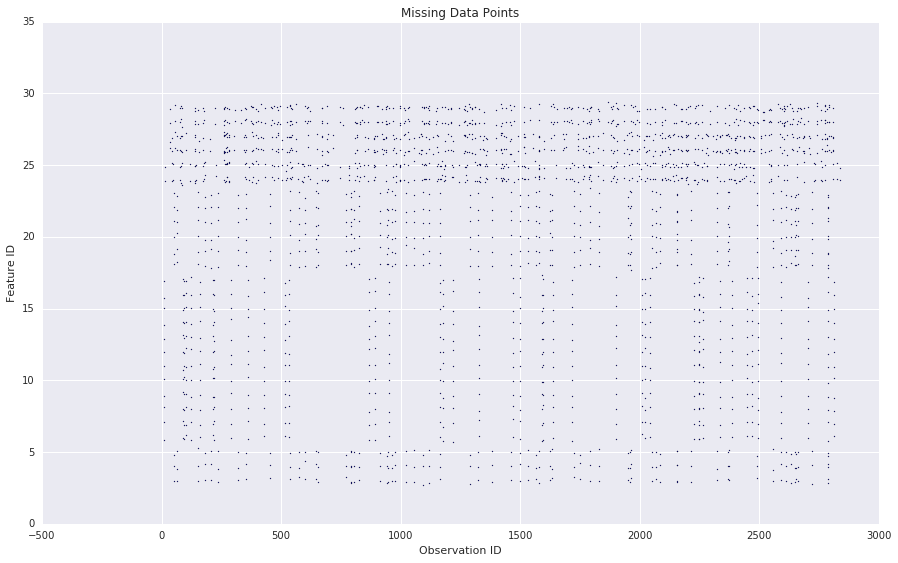

In [26]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 9.0)
def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev
_ = plt.scatter(nullspos[:,0], rand_jitter(nullspos[:,1]), s=1)
_ = plt.title('Missing Data Points')
_ = plt.ylabel('Feature ID')
_ = plt.xlabel('Observation ID')

Let's see one of them in detail:

In [27]:
%%sql
SELECT * FROM [datalab-projects-1331:xjk_algo_comp_test.gaps]
WHERE IS_NAN(gap_1_slots_ago) = true
  AND IS_NAN(gap_2_slots_ago) = true AND IS_NAN(gap_3_slots_ago) = true
LIMIT 1

district_id,timeslot,day_in_week,timeofday_slot,tj_level1_1_slots_ago,tj_level2_1_slots_ago,tj_level3_1_slots_ago,tj_level4_1_slots_ago,tj_level1_2_slots_ago,tj_level2_2_slots_ago,tj_level3_2_slots_ago,tj_level4_2_slots_ago,tj_level1_3_slots_ago,tj_level2_3_slots_ago,tj_level3_3_slots_ago,tj_level4_3_slots_ago,weather_1_slots_ago,temperature_1_slots_ago,pm25_1_slots_ago,weather_2_slots_ago,temperature_2_slots_ago,pm25_2_slots_ago,weather_3_slots_ago,temperature_3_slots_ago,pm25_3_slots_ago,gap_1_slots_ago,sum_price_1_slots_ago,gap_2_slots_ago,sum_price_2_slots_ago,gap_3_slots_ago,sum_price_3_slots_ago,f1,f11,f11_1,f11_2,f11_3,f11_4,f11_5,f11_6,f11_7,f11_8,f13_4,f13_8,f14,f14_1,f14_10,f14_2,f14_3,f14_6,f14_8,f15,f15_1,f15_2,f15_3,f15_4,f15_6,f15_7,f15_8,f16,f16_1,f16_10,f16_11,f16_12,f16_3,f16_4,f16_6,f17,f17_2,f17_3,f17_4,f17_5,f19,f19_1,f19_2,f19_3,f19_4,f1_1,f1_10,f1_11,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f20,f20_1,f20_2,f20_4,f20_5,f20_6,f20_7,f20_8,f20_9,f21_1,f21_2,f22,f22_1,f22_2,f22_3,f22_4,f22_5,f23,f23_1,f23_2,f23_3,f23_4,f23_5,f23_6,f24,f24_1,f24_2,f24_3,f25,f25_1,f25_3,f25_7,f25_8,f25_9,f2_1,f2_10,f2_11,f2_12,f2_13,f2_2,f2_4,f2_5,f2_6,f2_7,f2_8,f3_1,f3_2,f3_3,f4,f4_1,f4_10,f4_11,f4_13,f4_14,f4_16,f4_17,f4_18,f4_2,f4_3,f4_5,f4_6,f4_7,f4_8,f4_9,f5,f5_1,f5_3,f5_4,f6,f6_1,f6_2,f6_4,f7,f8,f8_1,f8_2,f8_3,f8_4,f8_5,gap,busy_time
15,2016-01-27-46,2.0,46.0,20.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,3.0,3.0,76.0,3.0,3.0,76.0,3.0,3.0,76.0,nan,nan,nan,nan,nan,nan,0.0,249.0,0.0,83.0,0.0,0.0,0.0,249.0,0.0,415.0,415.0,166.0,664.0,0.0,166.0,0.0,83.0,0.0,0.0,166.0,0.0,249.0,249.0,0.0,0.0,0.0,0.0,0.0,0.0,332.0,0.0,0.0,0.0,249.0,83.0,0.0,0.0,0.0,0.0,0.0,415.0,166.0,0.0,83.0,83.0,0.0,0.0,0.0,0.0,83.0,83.0,0.0,0.0,0.0,166.0,166.0,83.0,83.0,0.0,0.0,0.0,0.0,83.0,0.0,83.0,498.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,830.0,0.0,0.0,83.0,0.0,0.0,83.0,0.0,166.0,0.0,0.0,0.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1577.0,0.0,0.0,249.0,0.0,0.0,0.0,0.0,0.0,0.0,83.0,249.0,0.0,0.0,0.0,0.0,83.0,0.0,0.0,0.0,0.0,83.0,0.0,83.0,0.0,0.0,0.0,166.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Alright, `2016-01-27-46` is one of the test data to predict alright, as analyzed previously. Let's see orders from its past three slots.

In [28]:
%%sql
SELECT COUNT(*) AS num_of_orders, SUM(price) AS total_price
FROM [datalab-projects-1331:xjk_algo_comp_test.orders] AS orders
LEFT JOIN [datalab-projects-1331:xjk_algo_comp.districts] AS districts
  ON orders.start_district_hash = districts.district_hash
WHERE timeslot IN ('2016-01-18-45', '2016-01-18-44', '2016-01-18-43') AND district_id = 15

num_of_orders,total_price
0,


There was no order at these days, so we can confirm that these missing values should be replaced with zeroes. Let's analyze weather and traffic.

## Test Data - Analyze Weather

In [29]:
%%sql
SELECT * FROM [datalab-projects-1331:xjk_algo_comp_test.gaps]
WHERE IS_NAN(weather_1_slots_ago) = true
LIMIT 1

district_id,timeslot,day_in_week,timeofday_slot,tj_level1_1_slots_ago,tj_level2_1_slots_ago,tj_level3_1_slots_ago,tj_level4_1_slots_ago,tj_level1_2_slots_ago,tj_level2_2_slots_ago,tj_level3_2_slots_ago,tj_level4_2_slots_ago,tj_level1_3_slots_ago,tj_level2_3_slots_ago,tj_level3_3_slots_ago,tj_level4_3_slots_ago,weather_1_slots_ago,temperature_1_slots_ago,pm25_1_slots_ago,weather_2_slots_ago,temperature_2_slots_ago,pm25_2_slots_ago,weather_3_slots_ago,temperature_3_slots_ago,pm25_3_slots_ago,gap_1_slots_ago,sum_price_1_slots_ago,gap_2_slots_ago,sum_price_2_slots_ago,gap_3_slots_ago,sum_price_3_slots_ago,f1,f11,f11_1,f11_2,f11_3,f11_4,f11_5,f11_6,f11_7,f11_8,f13_4,f13_8,f14,f14_1,f14_10,f14_2,f14_3,f14_6,f14_8,f15,f15_1,f15_2,f15_3,f15_4,f15_6,f15_7,f15_8,f16,f16_1,f16_10,f16_11,f16_12,f16_3,f16_4,f16_6,f17,f17_2,f17_3,f17_4,f17_5,f19,f19_1,f19_2,f19_3,f19_4,f1_1,f1_10,f1_11,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f20,f20_1,f20_2,f20_4,f20_5,f20_6,f20_7,f20_8,f20_9,f21_1,f21_2,f22,f22_1,f22_2,f22_3,f22_4,f22_5,f23,f23_1,f23_2,f23_3,f23_4,f23_5,f23_6,f24,f24_1,f24_2,f24_3,f25,f25_1,f25_3,f25_7,f25_8,f25_9,f2_1,f2_10,f2_11,f2_12,f2_13,f2_2,f2_4,f2_5,f2_6,f2_7,f2_8,f3_1,f3_2,f3_3,f4,f4_1,f4_10,f4_11,f4_13,f4_14,f4_16,f4_17,f4_18,f4_2,f4_3,f4_5,f4_6,f4_7,f4_8,f4_9,f5,f5_1,f5_3,f5_4,f6,f6_1,f6_2,f6_4,f7,f8,f8_1,f8_2,f8_3,f8_4,f8_5,gap,busy_time
7,2016-01-23-58,5.0,58.0,1704.0,532.0,111.0,109.0,1746.0,516.0,130.0,87.0,1849.0,514.0,118.0,68.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,36.0,2353.1,44.0,1714.0,31.0,1680.3,3735.0,10873.0,7968.0,10956.0,9545.0,41334.0,8300.0,11371.0,3818.0,41832.0,50713.0,17015.0,5478.0,249.0,332.0,0.0,830.0,3735.0,747.0,10292.0,83.0,8217.0,10458.0,415.0,6225.0,2490.0,83.0,6308.0,83.0,25481.0,6806.0,2822.0,415.0,5976.0,0.0,996.0,7304.0,249.0,1660.0,9960.0,151641.0,996.0,415.0,134460.0,2241.0,166.0,83.0,1577.0,1660.0,996.0,664.0,8715.0,0.0,332.0,3984.0,13114.0,6391.0,6806.0,10956.0,3071.0,332.0,8383.0,34611.0,0.0,0.0,581.0,1328.0,1162.0,664.0,249.0,1577.0,1660.0,5063.0,1162.0,249.0,1494.0,498.0,747.0,1494.0,1494.0,184011.0,14691.0,2988.0,2988.0,249.0,1079.0,1992.0,1660.0,2739.0,664.0,1162.0,332.0,15106.0,5395.0,11371.0,83.0,913.0,18094.0,664.0,166.0,1411.0,249.0,415.0,13363.0,332.0,5727.0,2158.0,1992.0,2158.0,498.0,4233.0,2656.0,3237.0,747.0,2739.0,1411.0,2988.0,249.0,3652.0,332.0,8549.0,3486.0,0.0,20418.0,2241.0,3984.0,1079.0,7221.0,1162.0,166.0,10624.0,14691.0,7470.0,83.0,0.0,0


When was the closest date (from `2016-01-23-58`) where weather information exist?

In [30]:
%%sql --module weather_by_timeslot
SELECT FIRST(timeslot), COUNT(*) AS num_weather FROM [datalab-projects-1331:xjk_algo_comp_test.weather]
WHERE date IN ('2016-01-23')
GROUP BY date, timeofday_slot
ORDER BY date, timeofday_slot

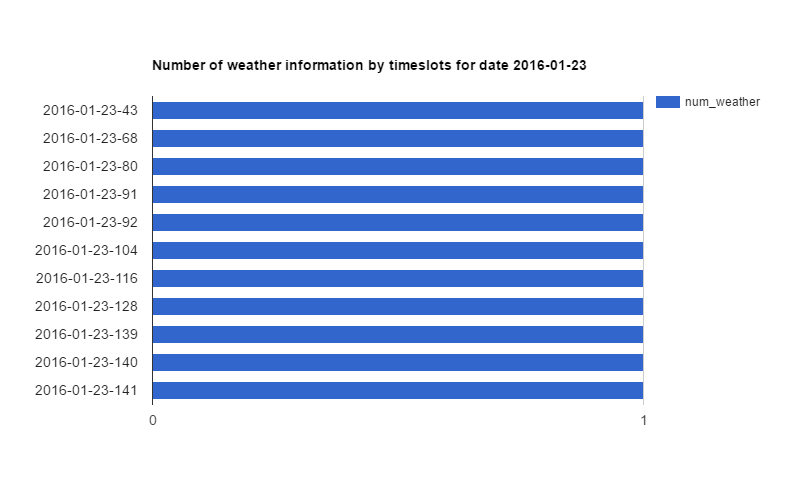

In [31]:
%%chart bars --data weather_by_timeslot
title: Number of weather information by timeslots for date 2016-01-23
height: 500
legend:
  textStyle:
    fontSize: 12
hAxis:
  format: "#"
  ticks: [0, 1]

The closest was from slot 43 it seems. By the way, did weather from slot 43 correctly used for 44 and 45? Let's see below.

In [32]:
%%sql
SELECT weather
FROM [datalab-projects-1331:xjk_algo_comp_test.weather]
WHERE timeslot = '2016-01-23-43'
LIMIT 1

weather
4


In [33]:
%%sql
SELECT weather_1_slots_ago, weather_2_slots_ago, weather_3_slots_ago
FROM [datalab-projects-1331:xjk_algo_comp_test.gaps]
WHERE district_id = 1 AND timeslot = '2016-01-23-46'
LIMIT 1

weather_1_slots_ago,weather_2_slots_ago,weather_3_slots_ago
4.0,4.0,4.0


Yep, confirmed. The big question here is, is it better to assume that weather doesn't change from previous readings? I don't currently know the answer, but I do know that it is inappropriate to set weather types, temperatures, and pollution levels to 0.

There are two ways to handle this:
1. Use past readings, or
2. Remove observations with missing weather information.

Let's see how weather information correlate with `gap` when handled by each method.

### Use Past Readings

Let's see how weather types, temperatures, and pollution levels change throughout the day. We need this to decide whether to impute missing values with past readings directly or should we use means or other methods. We shall use training data for this since it has arguably more observations.

In [34]:
%%sql --module weather_line
SELECT FIRST(weather.timeslot) AS timeslot, FIRST(weather) AS weather,
  FIRST(temperature) AS temperature, FIRST(pm25) AS pm25, SUM(gap) AS gap
FROM [datalab-projects-1331:xjk_algo_comp.weather] AS weather
  LEFT JOIN [datalab-projects-1331:xjk_algo_comp.gaps] AS gaps 
    ON gaps.timeslot = weather.timeslot
GROUP BY weather.date, weather.timeofday_slot
ORDER BY weather.date, weather.timeofday_slot

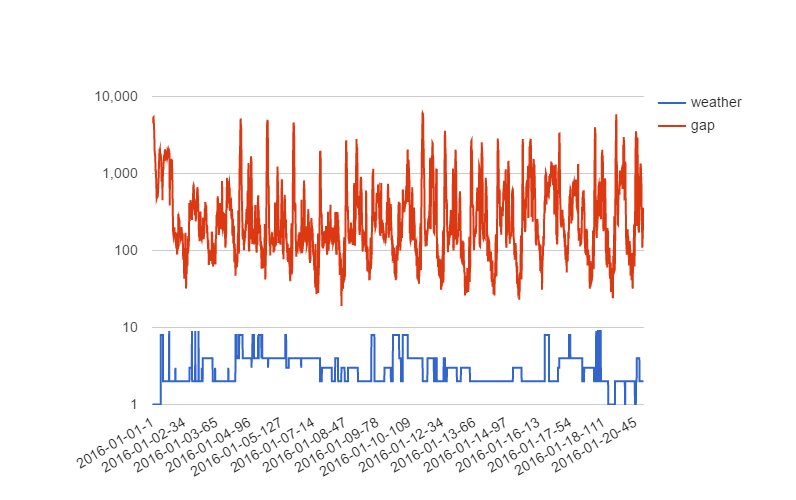

In [35]:
%%chart line --data weather_line --fields timeslot,weather,gap
height: 500
vAxis:
  scaleType: log

There doesn't seem to be that many variations with weather types, and I don't think it is appropriate anyway to get mean of categorical data (`weather` is categorical), so in this case we can use previous reading.

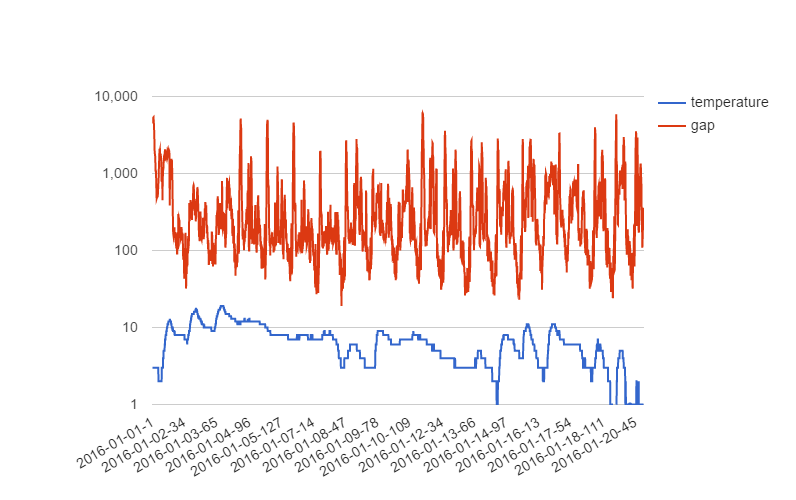

In [37]:
%%chart line --data weather_line --fields timeslot,temperature,gap
{
  "height": 500,
  "vAxis": {
    "scaleType": "log"
  }
}

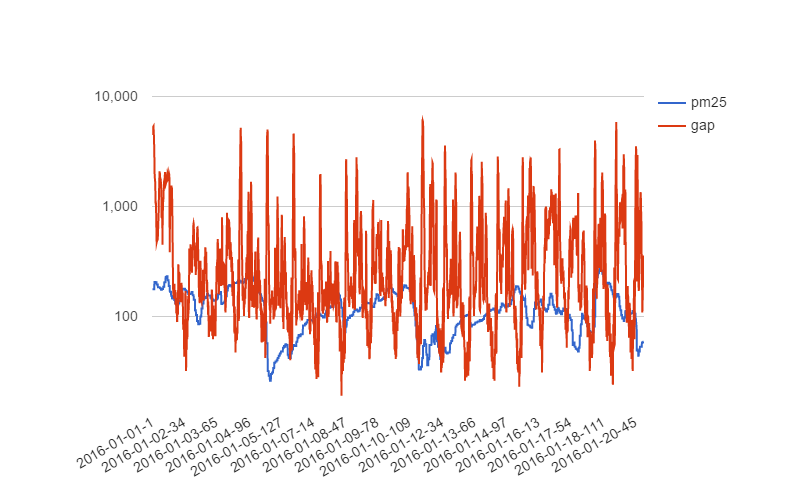

In [38]:
%%chart line --data weather_line --fields timeslot,pm25,gap
{
  "height": 500,
  "vAxis": {
    "scaleType": "log"
  }
}

There doesn't seem to be any correlation at all between weather types, temperatures, and pollution levels, with gap. Considering all the missing data as well, let's just not use this in model creation at all.

In [39]:
# Tried to plot trendline with pylab but didn't work

# import pylab

# df = bq.Query(weather_line).to_dataframe()

# # plot the data itself
# x = range(len(df['timeslot']))
# y = df['gap']
# pylab.xticks(x, df['timeslot'])
# pylab.plot(x,y)

# # calc the trendline
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# pylab.plot(x,p(x),"r--")


Let's do similar analysis with traffic information.

## Test Data - Analyze Traffic

In [40]:
%%sql
SELECT * FROM [datalab-projects-1331:xjk_algo_comp_test.gaps]
WHERE IS_NAN(tj_level1_1_slots_ago) = true AND IS_NAN(tj_level1_2_slots_ago) = true
  AND IS_NAN(tj_level1_3_slots_ago) = true
LIMIT 1

district_id,timeslot,day_in_week,timeofday_slot,tj_level1_1_slots_ago,tj_level2_1_slots_ago,tj_level3_1_slots_ago,tj_level4_1_slots_ago,tj_level1_2_slots_ago,tj_level2_2_slots_ago,tj_level3_2_slots_ago,tj_level4_2_slots_ago,tj_level1_3_slots_ago,tj_level2_3_slots_ago,tj_level3_3_slots_ago,tj_level4_3_slots_ago,weather_1_slots_ago,temperature_1_slots_ago,pm25_1_slots_ago,weather_2_slots_ago,temperature_2_slots_ago,pm25_2_slots_ago,weather_3_slots_ago,temperature_3_slots_ago,pm25_3_slots_ago,gap_1_slots_ago,sum_price_1_slots_ago,gap_2_slots_ago,sum_price_2_slots_ago,gap_3_slots_ago,sum_price_3_slots_ago,f1,f11,f11_1,f11_2,f11_3,f11_4,f11_5,f11_6,f11_7,f11_8,f13_4,f13_8,f14,f14_1,f14_10,f14_2,f14_3,f14_6,f14_8,f15,f15_1,f15_2,f15_3,f15_4,f15_6,f15_7,f15_8,f16,f16_1,f16_10,f16_11,f16_12,f16_3,f16_4,f16_6,f17,f17_2,f17_3,f17_4,f17_5,f19,f19_1,f19_2,f19_3,f19_4,f1_1,f1_10,f1_11,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f20,f20_1,f20_2,f20_4,f20_5,f20_6,f20_7,f20_8,f20_9,f21_1,f21_2,f22,f22_1,f22_2,f22_3,f22_4,f22_5,f23,f23_1,f23_2,f23_3,f23_4,f23_5,f23_6,f24,f24_1,f24_2,f24_3,f25,f25_1,f25_3,f25_7,f25_8,f25_9,f2_1,f2_10,f2_11,f2_12,f2_13,f2_2,f2_4,f2_5,f2_6,f2_7,f2_8,f3_1,f3_2,f3_3,f4,f4_1,f4_10,f4_11,f4_13,f4_14,f4_16,f4_17,f4_18,f4_2,f4_3,f4_5,f4_6,f4_7,f4_8,f4_9,f5,f5_1,f5_3,f5_4,f6,f6_1,f6_2,f6_4,f7,f8,f8_1,f8_2,f8_3,f8_4,f8_5,gap,busy_time
54,2016-01-29-142,4.0,142.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.0,4.0,61.0,3.0,4.0,61.0,3.0,4.0,61.0,0.0,380.0,2.0,303.0,0.0,199.0,581.0,2739.0,83.0,747.0,1328.0,3818.0,249.0,2158.0,581.0,7221.0,2407.0,0.0,0.0,0.0,0.0,83.0,83.0,83.0,0.0,1494.0,83.0,581.0,1162.0,83.0,581.0,581.0,0.0,2158.0,83.0,1577.0,0.0,166.0,332.0,332.0,0.0,249.0,1328.0,0.0,0.0,1328.0,20584.0,2241.0,332.0,3901.0,332.0,83.0,83.0,498.0,498.0,249.0,83.0,2407.0,0.0,0.0,1411.0,10458.0,4233.0,830.0,2407.0,498.0,249.0,7304.0,12118.0,0.0,0.0,0.0,3735.0,415.0,1577.0,5395.0,2490.0,1328.0,83.0,83.0,0.0,166.0,0.0,0.0,83.0,166.0,2075.0,747.0,0.0,664.0,0.0,0.0,1079.0,0.0,1992.0,0.0,747.0,0.0,249.0,0.0,1162.0,0.0,498.0,996.0,581.0,0.0,2241.0,0.0,166.0,1411.0,166.0,166.0,415.0,0.0,498.0,83.0,415.0,249.0,2490.0,249.0,332.0,166.0,0.0,249.0,498.0,0.0,498.0,83.0,0.0,3569.0,166.0,498.0,83.0,2158.0,0.0,0.0,1328.0,249.0,1328.0,0.0,0.0,0


In [41]:
%%sql --module traffic_by_timeslot
SELECT FIRST(timeslot), COUNT(*) AS num_traffic
FROM [datalab-projects-1331:xjk_algo_comp_test.traffic] AS traffic
JOIN [datalab-projects-1331:xjk_algo_comp_test.districts] AS districts
  ON traffic.district_hash = districts.district_hash
WHERE date IN ('2016-01-29') AND district_id = 54
GROUP BY date, timeofday_slot, district_id
ORDER BY date, timeofday_slot, district_id

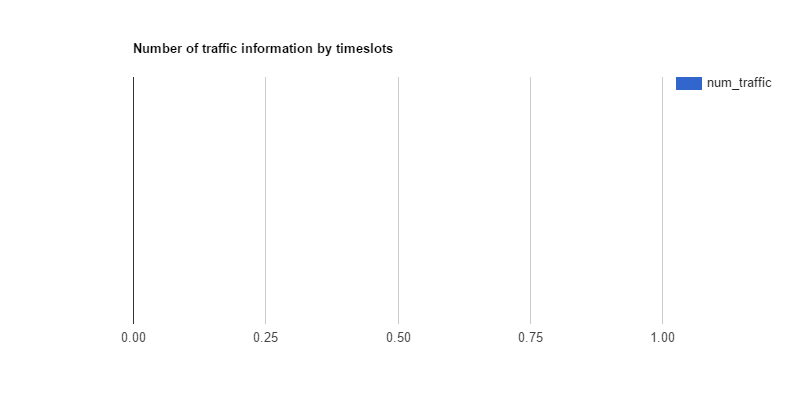

In [42]:
%%chart bars --data traffic_by_timeslot
title: Number of traffic information by timeslots
height: 400

Seems like district 54 had no traffic information on that date. Let's see if this district had any traffic information at all.

In [43]:
%%sql
SELECT FIRST(timeslot) AS timeslot, COUNT(*) AS num_traffic
FROM [datalab-projects-1331:xjk_algo_comp_test.traffic] AS traffic
JOIN [datalab-projects-1331:xjk_algo_comp_test.districts] AS districts
  ON traffic.district_hash = districts.district_hash
WHERE district_id = 54
GROUP BY date, timeofday_slot
ORDER BY date, timeofday_slot

QueryResultsTable job_WhJVoEphDeMUmcbmkvFYsS7a3qs

Nope, seems like district 54 never had any traffic information. What other districts do not have traffic information as well?

In [44]:
%%sql
SELECT district_id, COUNT(*) AS num_traffic
FROM [datalab-projects-1331:xjk_algo_comp_test.traffic] AS traffic
RIGHT OUTER JOIN EACH [datalab-projects-1331:xjk_algo_comp_test.districts] AS districts
  ON traffic.district_hash = districts.district_hash
GROUP BY district_id
ORDER BY num_traffic

district_id,num_traffic
54,1
15,254
26,258
24,258
66,258
25,258
61,258
20,258
48,258
50,258


There is one row, what happened? Turns out it is an empty row as shown below:

In [45]:
%%sql
SELECT *
FROM [datalab-projects-1331:xjk_algo_comp_test.traffic] AS traffic
RIGHT JOIN EACH [datalab-projects-1331:xjk_algo_comp_test.districts] AS districts
  ON traffic.district_hash = districts.district_hash
WHERE district_id = 54

traffic_district_hash,traffic_tj_level1,traffic_tj_level2,traffic_tj_level3,traffic_tj_level4,traffic_tj_time,traffic_timeslot,traffic_timeofday_slot,traffic_day_in_week,traffic_date,districts_district_hash,districts_district_id
,,,,,,,,,,c4ec24e0a58ebedaa1661e5c09e47bb5,54


How about in training data?

In [46]:
%%sql
SELECT district_id, COUNT(*) AS num_traffic
FROM [datalab-projects-1331:xjk_algo_comp.traffic] AS traffic
RIGHT OUTER JOIN EACH [datalab-projects-1331:xjk_algo_comp_test.districts] AS districts
  ON traffic.district_hash = districts.district_hash
GROUP BY district_id
ORDER BY num_traffic

district_id,num_traffic
54,1
15,2837
63,2977
32,2979
64,2980
14,2980
29,2980
1,2980
5,2980
35,2980


# Conclusion Thus Far

For traffic information, tn test data district 54 has none of it and district 15 has 4 missing traffic information. In training data, district 54 has no traffic information, 15 has 153 missing information, 63 has 13, and 32 has 1.

Perhaps it is better not to include district 54 when training the model, or train it separately.

There was a prevalent trend where weather information was missing from test data, as it had been seen on training data, but this trend is irrelevant since there was no correlation between weather and gaps. Further analysis may show different conclusion, but let's not include weather information at all for now.

I suspect that these missing traffic and weather info on some districts caused the pattern when these missing data points were plotted. We shall confirm this soon.

# Handle Missing Data
In the next couple of sections, we will see how the handling of missing data will affect performance.

We will do a quick spot-checking, that is to create a baseline model with fast-running algorithm, then compare its performance with and without preprocessing missing data as explained above.

The data will be tested with DecisionTree algorithm, and it will be cross-validated with 10-kfold splits. We won't do any grid search at this step as we only want to see if missing data handling works.

In [48]:
# Store list of fields in a Pickle object so we don't have to rewrite everything.
try:
  import cPickle as pickle
except:
  import pickle

FIELDS_PICKLE = 'fields-4.pkl'
pickle.dump(fields, open(FIELDS_PICKLE, "w") )